## Label prediction with Cars dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Getting the data

In [3]:
path = 'dataset'

In [4]:
!pwd

/home/jupyter/cars_classification


## Classification

In [5]:
df = pd.read_csv(os.path.join(path, 'df_train.csv'))
df.head()

,fname,class
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

## More Augmentations
(Tried more augmentaion techniques like Jitter, Crop-Pad, but the didn't seem to improve the model as of now)

In [6]:
# tfms_xtra = [fastai.vision.transform.jitter(magnitude=(-.005, .005), p=.75), fastai.vision.transform.crop_pad()]
# tfms = get_transforms (do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, 
#                        max_lighting=0.2, max_warp=0.1, p_affine=0.75, p_lighting=0.75, xtra_tfms = tfms_xtra)

In [7]:
tfms = get_transforms(flip_vert=False, max_lighting=0.2, max_zoom=1.1, max_warp=0.2)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [8]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'df_train.csv', folder='cars_train', suffix='')
       .split_by_rand_pct(0.2)
       .label_from_df())

In [9]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

## Sample Data

`show_batch` still works, and show us the different labels separated by `;`.

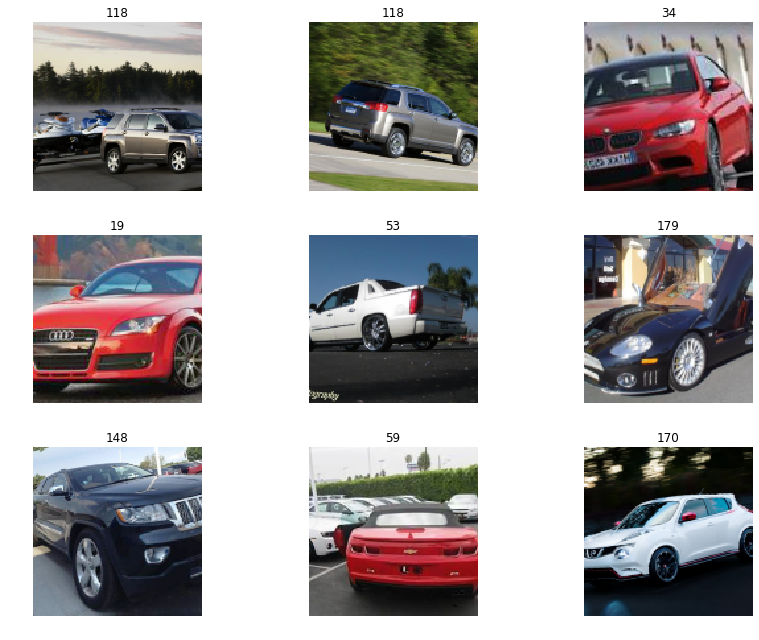

In [10]:
data.show_batch(rows=3, figsize=(12,9))

## Model architecture for transfer learning

In [11]:
arch = models.resnet152

In [12]:
len(data.classes),data.c

(196, 196)

In [13]:
learn = cnn_learner(data, arch, metrics=accuracy)

We use the LR Finder to pick a good learning rate.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01 * 2

In [ ]:
learn.fit_one_cycle(35, slice(lr))

In [ ]:
learn.save('stage-1-rn152')

### Tuning all the layers of the model now

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(30, slice(1e-7, lr/5))

In [ ]:
learn.save('stage-2-rn152')

### Training with bigger size images - 256 x 256

In [14]:
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
# learn.data.batch_size = 16
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [15]:
learn.load('stage-2-rn152')

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
14,3,91,134,106
Path: dataset;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
172,126,10,105,20
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kerne

In [16]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


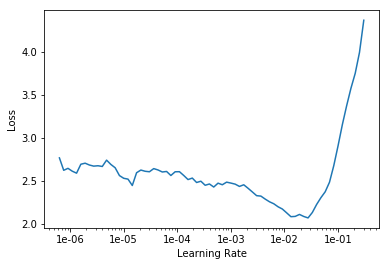

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr=1e-3 * 2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('stage-1-256-rn152')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-7, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn152')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## Validation

In [ ]:
test = ImageList.from_folder(os.path.join(path,"cars_test"))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# TODO : Log confidence of the each predicted class later
log_preds = np.argmax (preds, axis = 1)
print(type(log_preds))

In [ ]:
result = log_preds.data.numpy()
print (result)

In [ ]:
# Adding one as predictions are '0' index based
result_submit = result + 1
print (result_submit)

Saving results in text file

In [ ]:
np.savetxt ("submission_vj", result_submit, delimiter=';',fmt='%i',newline='\r\n')